In [58]:
%matplotlib inline

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

from qiskit.finance.data_providers import *
from qiskit.finance import QiskitFinanceError

from docplex.mp.model import Model

from qiskit.aqua.components.optimizers import COBYLA
register_matplotlib_converters()

[*********************100%***********************]  5 of 5 completed


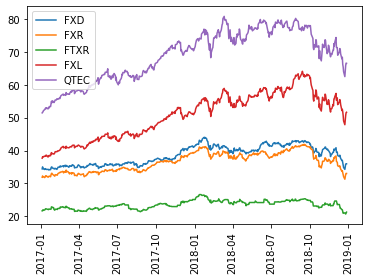

In [59]:
# just some plotting, to visualize data. NB: be sure that every time series is
# defined over the entire observation period
try:
    data = YahooDataProvider(
                 tickers = ['FXD', 'FXR', 'FTXR', 'FXL', 'QTEC'], # IFV ETF 
                 start=datetime.datetime(2017, 1, 1),
                 end=datetime.datetime(2018, 12, 31))
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)

In [60]:
# Quantum Aggregator Wrapper

# Import algorithms 
import grovers_search as grovers
import optim_wrapper as optimization


def aggregator(algorithm, dict_details):
    if algorithm == 'grovers':
        result = grovers.grovers_search(dict_details)
    if algorithm == 'optimizer':
        result = optimization.optimize_portfolio(dict_details)
    return result

In [61]:
solvers = ['vqe', 'classic']
overall_results = {s : {} for s in solvers}

In [62]:
start = start=datetime.datetime(2017, 1, 1)
end = datetime.datetime(2018, 12, 31)

# Loads data, thus enabling get_similarity_matrix and
# get_covariance_matrix methods in the base class
data = YahooDataProvider(
             tickers = ['FXD', 'FXR', 'FTXR', 'FXL', 'QTEC'], # IFV ETF 
             start=start,
             end=end)
data.run()

# prepare problem instance
n = 5            # number of assets
q = 0.5          # risk factor
budget = n // 2  # budget
penalty = 2*n    # scaling of penalty term
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

# create docplex model
mdl = Model('portfolio_optimization')
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))
objective = mdl.sum([mu[i]*x[i] for i in range(n)])
objective -= q * mdl.sum([sigma[i,j]*x[i]*x[j] for i in range(n) for j in range(n)])
mdl.maximize(objective)
mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)

[*********************100%***********************]  5 of 5 completed


docplex.mp.LinearConstraint[](x0+x1+x2+x3+x4,EQ,2)

In [63]:
# vqe

In [64]:
optim_dict = {
  "docplex_mod": mdl,
  "quantum_instance": 'qasm_simulator',
  "shots": 1024,
  "print": True,
  "solver": solvers[0],
  "optimizer":COBYLA,
  "maxiter":1000,
  "depth":1,
  "alpha":0.35,
  "penalty": 2*n
}

results = aggregator('optimizer', optim_dict)

2021-04-01 18:05:04,020:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.4
Backend: 'qasm_simulator (AerProvider)', with following setting:
{'basis_gates': ['ccx', 'cp', 'cswap', 'csx', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'kraus', 'mcp', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcy', 'mcz', 'multiplexer', 'p', 'r', 'roerror', 'rx', 'rxx', 'ry', 'ryy', 'rz', 'rzx', 'rzz', 's', 'sdg', 'snapshot', 'swap', 'sx', 't', 'tdg', 'u', 'u1', 'u2', 'u3', 'unitary', 'x', 'y', 'z'], 'coupling_map': None}
{'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2021-04-01 18:05:04,029:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: <qiskit.aqua.operators.conve

### Original problem:
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolio_optimization

Maximize
 obj: 0.000128672713 x0 + 0.000118125844 x1 + 0.000011195401 x2
      + 0.000713887604 x3 + 0.000589785175 x4 + [ - 0.000081820055 x0^2
      - 0.000146380523 x0*x1 - 0.000060124169 x0*x2 - 0.000165042443 x0*x3
      - 0.000155278666 x0*x4 - 0.000094073690 x1^2 - 0.000072644952 x1*x2
      - 0.000186558762 x1*x3 - 0.000177259448 x1*x4 - 0.000095991633 x2^2
      - 0.000050340051 x2*x3 - 0.000046009026 x2*x4 - 0.000162878128 x3^2
      - 0.000291656201 x3*x4 - 0.000149996155 x4^2 ]/2
Subject To
 c0: x0 + x1 + x2 + x3 + x4 = 2

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End

### quadratic_program_to_qubo:
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolio_optimization

Maximize
 obj: 4.010247447467 x0 + 4.010236900597 x1 + 4.010129970154 x2
      + 4.010832662

2021-04-01 18:05:04,234:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.50339506] - 44.46292 (ms), eval count: 4
2021-04-01 18:05:04,236:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98991 (ms)
2021-04-01 18:05:04,287:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.50347817] - 51.82719 (ms), eval count: 5
2021-04-01 18:05:04,290:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99993 (ms)
2021-04-01 18:05:04,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.50362459] - 46.35215 (ms), eval count: 6
2021-04-01 18:05:04,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11318 (ms)
2021-04-01 18:05:04,376:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.50356757] - 40.49301 (ms), eval count: 7
2021-04-01 18:05:04,378:qiskit.aqua.operators.converte

### Results:
{'computational_time': 3.9433016589998715, 'result': optimal function value: 0.0006376900047319164
optimal value: [1. 0. 0. 1. 0.]
status: SUCCESS}


In [65]:
comp_time = results['computational_time']
res = results['result']
ret = sum([mu[i]*res.x[i] for i in range(n)])
vol = q * sum([sigma[i,j]*res.x[i]*res.x[j] for i in range(n) for j in range(n)])
value = ret-vol 
assert math.isclose(value, res.fval, abs_tol=1e-10)
print(f"objective function value: {value}, return term: {ret}, volatility term: {vol}, time {comp_time}")

objective function value: 0.0006376900047319164, return term: 0.0008425603175838039, volatility term: 0.00020487031285188753, time 3.9433016589998715


In [66]:
overall_results[solvers[0]][end] = (value, ret, vol, comp_time)
overall_results

{'vqe': {datetime.datetime(2018, 12, 31, 0, 0): (0.0006376900047319164,
   0.0008425603175838039,
   0.00020487031285188753,
   3.9433016589998715)},
 'classic': {}}

In [67]:
optim_dict = {
  "docplex_mod": mdl,
  "quantum_instance": 'qasm_simulator',
  "shots": 1024,
  "print": True,
  "solver": solvers[1],
  "optimizer":COBYLA,
  "maxiter":1000,
  "depth":1,
  "alpha":0.35,
  "penalty": 2*n
}
results = aggregator('optimizer', optim_dict)

2021-04-01 18:05:08,028:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-1.50433022+0.j]),
    'eigvecs': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]]),
    'energies': array([-1.50433022]),
    'energy': -1.5043302163965773,
    'wavefunction': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])}
2021-04-01 18:05:08,031:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
            

### Original problem:
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolio_optimization

Maximize
 obj: 0.000128672713 x0 + 0.000118125844 x1 + 0.000011195401 x2
      + 0.000713887604 x3 + 0.000589785175 x4 + [ - 0.000081820055 x0^2
      - 0.000146380523 x0*x1 - 0.000060124169 x0*x2 - 0.000165042443 x0*x3
      - 0.000155278666 x0*x4 - 0.000094073690 x1^2 - 0.000072644952 x1*x2
      - 0.000186558762 x1*x3 - 0.000177259448 x1*x4 - 0.000095991633 x2^2
      - 0.000050340051 x2*x3 - 0.000046009026 x2*x4 - 0.000162878128 x3^2
      - 0.000291656201 x3*x4 - 0.000149996155 x4^2 ]/2
Subject To
 c0: x0 + x1 + x2 + x3 + x4 = 2

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End

### Results:
{'computational_time': 0.0353621290000774, 'result': optimal function value: 0.0010014075374217438
optimal value: [0. 0. 0. 1. 1.]
status: SUCCESS}


In [68]:
comp_time = results['computational_time']
res = results['result']
ret = sum([mu[i]*res.x[i] for i in range(n)])
vol = q * sum([sigma[i,j]*res.x[i]*res.x[j] for i in range(n) for j in range(n)])
value = ret-vol 
assert math.isclose(value, res.fval, abs_tol=1e-10)
print(f"objective function value: {value}, return term: {ret}, volatility term: {vol}, time {comp_time}")

objective function value: 0.0010014075374217436, return term: 0.0013036727792514826, volatility term: 0.000302265241829739, time 0.0353621290000774


In [69]:
overall_results[solvers[1]][end] = (value, ret, vol, comp_time)
overall_results

{'vqe': {datetime.datetime(2018, 12, 31, 0, 0): (0.0006376900047319164,
   0.0008425603175838039,
   0.00020487031285188753,
   3.9433016589998715)},
 'classic': {datetime.datetime(2018, 12, 31, 0, 0): (0.0010014075374217436,
   0.0013036727792514826,
   0.000302265241829739,
   0.0353621290000774)}}

In [72]:
(np.array(overall_results[solvers[0]][end][0])-np.array(np.array(overall_results[solvers[1]][end][0])))/np.array(overall_results[solvers[1]][end][0])

-0.3632063062220065

In [ ]:
from datetime import date, timedelta

def dates_gen(start, end, delta):
    curr = start
    while curr < end:
        yield curr, min(curr + delta, end)
        curr += delta